## Imports

In [26]:
from identify_candlestick import recognize_candlestick
from keras.layers import Dropout
from  tensorflow.keras import models
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
import sys
import os
import talib
import numpy as np
import pandas as pd
from pandas_datareader import data as pdr
import matplotlib.pyplot as plt
# import yfinance as yf
import seaborn as sns
from datetime import datetime
from os import listdir
import random
random.seed(42)
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')

# Util functions


In [27]:
def add_analysis_to_dataset(dataset):
    dataset['H-L'] = dataset['High'] - dataset['Low']
    dataset['O-C'] = dataset['Close'] - dataset['Open']
    dataset['3day MA'] = dataset['Close'].shift(1).rolling(window=3).mean()
    dataset['10day MA'] = dataset['Close'].shift(1).rolling(window=10).mean()
    dataset['30day MA'] = dataset['Close'].shift(1).rolling(window=30).mean()
    dataset['60day MA'] = dataset['Close'].shift(1).rolling(window=60).mean()
    dataset['Std_dev'] = dataset['Close'].rolling(5).std()
    dataset['RSI'] = talib.RSI(dataset['Close'].values, timeperiod=9)
    dataset['Williams %R'] = talib.WILLR(dataset['High'].values, dataset['Low'].values, dataset['Close'].values, 7)
    dataset['Cmo'] = talib.CMO(dataset['Close'].values,  timeperiod=4)
    dataset["ADX"] = talib.ADX(dataset['High'].values, dataset['Low'].values, dataset['Close'].values)
    dataset["ADXR"] = talib.ADXR(dataset['High'].values, dataset['Low'].values, dataset['Close'].values)
    dataset["APO"] = talib.APO(dataset['Close'].values)
    dataset["BOP"] = talib.BOP(dataset['Open'].values, dataset['High'].values,dataset['Low'].values, dataset['Close'].values)
    dataset["CCI"] = talib.CCI(dataset['High'].values, dataset['Low'].values, dataset['Close'].values)
    dataset["CMO"] = talib.CMO(dataset['Close'].values)
    dataset["DX"] = talib.DX(dataset['High'].values,dataset['Low'].values, dataset['Close'].values)
    dataset["MFI"] = talib.MFI(dataset['Open'].values, dataset['High'].values, dataset['Low'].values, dataset['Close'].values)
    dataset["MINUS_DI"] = talib.MINUS_DI(dataset['High'].values, dataset['Low'].values, dataset['Close'].values)
    dataset["MOM"] = talib.MOM(dataset['Close'].values)
    dataset["PLUS_DI"] = talib.PLUS_DI(dataset['High'].values, dataset['Low'].values, dataset['Close'].values)
    dataset["PPO"] = talib.PPO(dataset['Close'].values)
    dataset["ROCP"] = talib.ROCP(dataset['Close'].values)
    dataset["ROCR"] = talib.ROCR(dataset['Close'].values)
    dataset["TRIX"] = talib.TRIX(dataset['Close'].values)
    dataset["ULTOSC"] = talib.ULTOSC(dataset['High'].values, dataset['Low'].values, dataset['Close'].values)
    dataset["TSF"] = talib.TSF(dataset['Close'].values, timeperiod=14)
    dataset["STDDEV"] = talib.STDDEV(dataset['Close'].values, timeperiod=5, nbdev=1)
    dataset = recognize_candlestick(dataset)
    dataset = dataset.drop(columns=["candlestick_match_count"])
    dataset = dataset.drop(columns=["candlestick_pattern"])
    dataset['returns'] = dataset["Close"].pct_change()
    dataset["log_returns"] = np.log(1 + dataset["returns"])
    
    return dataset

In [28]:
def create_regression_model(shape):
    mod=Sequential()
    mod.add(Dense(32, kernel_initializer='normal',input_dim = shape, activation='relu'))
    mod.add(Dense(64, kernel_initializer='normal',activation='relu'))
    mod.add(Dense(128, kernel_initializer='normal',activation='relu'))
    mod.add(Dense(256, kernel_initializer='normal',activation='relu'))
    mod.add(Dense(1, kernel_initializer='normal',activation='linear'))

    mod.compile(loss='mean_absolute_error', optimizer='adam', metrics=['accuracy','mean_absolute_error'])
    return mod

In [29]:
def create_LSTM_model(shape):
    model = Sequential()
    model.add(LSTM(200, return_sequences = True, input_shape = shape))
    model.add(Dropout(0.2))
    model.add(LSTM(units=100, return_sequences = True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=100, return_sequences = True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=100, return_sequences = False))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    
    model.compile(optimizer = 'adam', loss = 'mean_squared_error') 
    return model

In [30]:
def rescale_data(trainpredict, testpredict, scaler, ytest):
    z1 = np.zeros(trainpredict.shape)
    z2 = np.zeros(testpredict.shape)
    zero = len(X[0])-1
    print(zero)
    for i in range(zero):
        trainpredict = np.c_[trainpredict, z1]
        testpredict = np.c_[testpredict, z2]

    trainpredict = scaler.inverse_transform(trainpredict)
    trainpredict = [x[0] for x in trainpredict]

    testpredict = scaler.inverse_transform(testpredict)
    testpredict = [x[0] for x in testpredict]

    z3 = np.zeros(ytest.shape)
    for i in range(zero):
        ytest = np.c_[ytest, z3]
        
    ytestscaled = scaler.inverse_transform(ytest)
    ytestscaled = [x[0] for x in ytestscaled]
    
    return trainpredict, testpredict, ytestscaled

In [31]:
def generate_triggers(testpredict, ytestscaled):
    df = pd.DataFrame()
    df["preds"] = testpredict
    df["price_tomorrow"] = ytestscaled
    df["price_today"] = df["price_tomorrow"].shift(1)
    df = df.dropna()

    df["change"] = df.apply(lambda x: x["preds"] - x["price_today"] ,axis=1)
    df["trigger"] = np.where(df["change"]>0.0,1,0)
    df["good_days"] = np.where(df["price_tomorrow"]>df["price_today"],1,0)

    pred = df["trigger"] == 1
    y_pred = np.array(pred)

    df["Close"] = df["price_today"]
    df['y_pred'] = y_pred
    
    return df.dropna()

In [32]:
def plot_results(trade_dataset):
        
    trade_dataset['Tomorrows Returns'] = 0.
    trade_dataset['Tomorrows Returns'] = trade_dataset['Close'] - trade_dataset['Close'].shift(1)
    trade_dataset['Tomorrows Returns'] = trade_dataset['Tomorrows Returns'].shift(-1)

    trade_dataset['Strategy Returns'] = 0.
    trade_dataset['Strategy Returns'] = np.where(trade_dataset['y_pred'] == True, trade_dataset['Tomorrows Returns'], 0)

    trade_dataset['Cumulative Market Returns'] = np.cumsum(trade_dataset['Tomorrows Returns'])
    trade_dataset['Cumulative Strategy Returns'] = np.cumsum(trade_dataset['Strategy Returns'])
    
    trade_dataset["buy"] = np.where((trade_dataset['y_pred'] == True) & (trade_dataset['y_pred'].shift(1) == False), 1, 0)
    trade_dataset["buy_spot"] = np.where((trade_dataset["buy"] == 1), trade_dataset["Cumulative Market Returns"], 0)

    trade_dataset["sell"] = np.where((trade_dataset['y_pred'] == False) & (trade_dataset['y_pred'].shift(1) == True), 1, 0)
    trade_dataset["sell_spot"] = np.where((trade_dataset["sell"] == 1), trade_dataset["Cumulative Market Returns"], 0)
                          
    # Plotting data
    plt.style.use('seaborn-bright')
    plt.figure(figsize=(20, 10))
    plt.plot(trade_dataset['Cumulative Market Returns'], color='black', label='Market Returns')
    plt.plot(trade_dataset['Cumulative Strategy Returns'], color='g', label='Strategy Returns')

    plt.scatter(range(len(trade_dataset["buy_spot"])), trade_dataset["buy_spot"], marker="x",s=80, label="buy", color='b')
    plt.scatter(range(len(trade_dataset["sell_spot"])), trade_dataset["sell_spot"],marker="x",s=80, label="sell", color='r')
    plt.legend()
    plt.show()

    print("Total market return: " + str(trade_dataset['Cumulative Market Returns'].iloc[-2]))
    print("Total strategy return: " + str(trade_dataset['Cumulative Strategy Returns'].iloc[-2]))
    print("Total number of purchases prediction: " + str(sum(trade_dataset["buy"])))
    print("Total number of actual purchases: " + str(sum(trade_dataset["y_pred"])))
    print("Total correct predicted days: " + str(len(trade_dataset[(trade_dataset["y_pred"] == True)  & (trade_dataset["Tomorrows Returns"] > 0)])))
    print("Total number of days: " + str(len(trade_dataset)))

# Training Regression model

Nr. 0/1
Epoch 1/30
28/28 [==============================] - 0s 16ms/step - loss: 0.1023 - accuracy: 2.8490e-04 - mean_absolute_error: 0.1023 - val_loss: 0.2604 - val_accuracy: 0.0000e+00 - val_mean_absolute_error: 0.2604
Epoch 2/30
28/28 [==============================] - 0s 6ms/step - loss: 0.0661 - accuracy: 2.8490e-04 - mean_absolute_error: 0.0661 - val_loss: 0.1904 - val_accuracy: 0.0000e+00 - val_mean_absolute_error: 0.1904
Epoch 3/30
28/28 [==============================] - 0s 8ms/step - loss: 0.0278 - accuracy: 2.8490e-04 - mean_absolute_error: 0.0278 - val_loss: 0.0636 - val_accuracy: 0.0000e+00 - val_mean_absolute_error: 0.0636
Epoch 4/30
28/28 [==============================] - 0s 6ms/step - loss: 0.0151 - accuracy: 2.8490e-04 - mean_absolute_error: 0.0151 - val_loss: 0.0411 - val_accuracy: 0.0000e+00 - val_mean_absolute_error: 0.0411
Epoch 5/30
28/28 [==============================] - 0s 6ms/step - loss: 0.0132 - accuracy: 2.8490e-04 - mean_absolute_error: 0.0132 - val_loss:

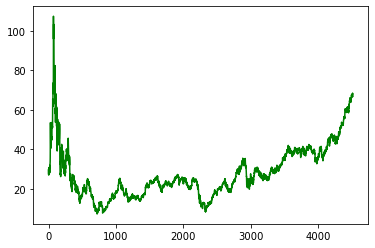

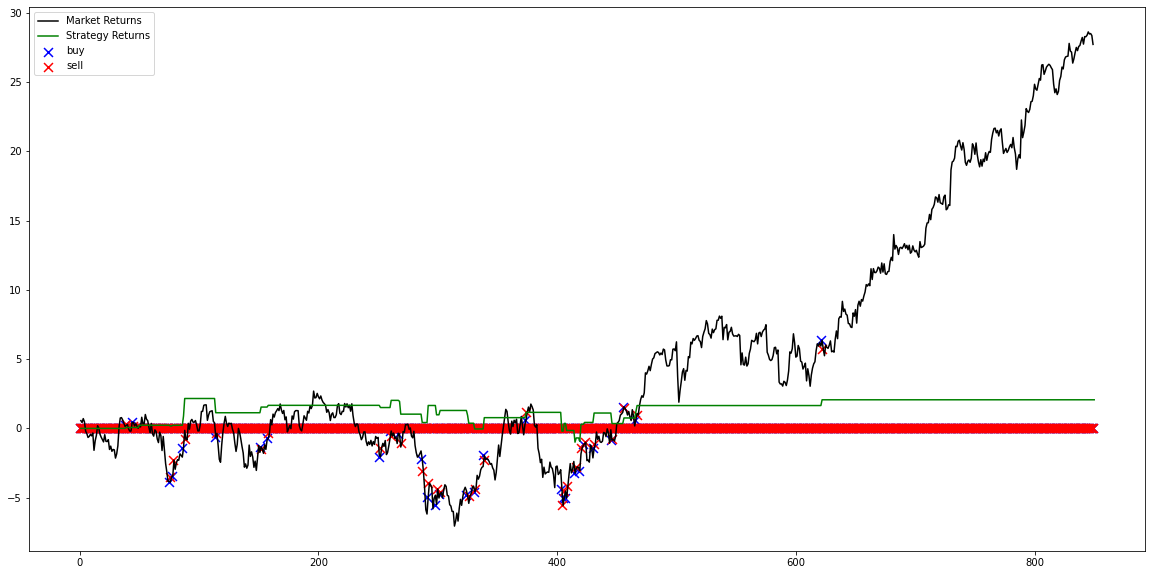

Total market return: 27.719
Total strategy return: 2.0649999999999977
Total number of purchases prediction: 31
Total number of actual purchases: 37
Total correct predicted days: 21
Total number of days: 850


In [33]:
path = r"../data/Stocks/"
files = listdir(path)

# Remove the list limiter [0:1] from files[0:1] in order to train the model with all the data
for indx, file in enumerate(files[0:1]):
    print("Nr. "+str(indx) +"/"+ str(len(files[0:1])))
    dataset = pd.DataFrame()
    dataset = pd.read_csv(path + file)
    if len(dataset) < 800 and indx != 0:
        print("Dataset smaller then 800 skipping ...")
        continue

    # Casting the data to float
    dataset["Open"] = dataset["Open"].astype(float)
    dataset["High"] = dataset["High"].astype(float)
    dataset["Low"] = dataset["Low"].astype(float)
    dataset["Close"] = dataset["Close"].astype(float)

    # Plotting stock closing price
    plt.plot(dataset["Close"],color='g', label='close price')

    # Remove unmeaningfull data 
    dataset = dataset.dropna()
    dataset = dataset.reset_index()
    dataset = dataset[['Close', 'High', 'Low', 'Open']]

    # Engineering data 
    dataset = add_analysis_to_dataset(dataset)
    dataset.head()

    # Cleaning
    dataset.dropna(inplace=True)
    X = dataset.drop(columns=["returns"]).values

    # Scaling
    scaler = MinMaxScaler(feature_range=(0,1)).fit(X)
    x_scaled = scaler.transform(X)

    # Splitting data
    y = [x[0] for x in x_scaled]
    split = int(len(x_scaled) *0.8)

    x_train = x_scaled[:split]
    x_test = x_scaled[split: len(x_scaled)]
    y_train = y[:split]
    y_test = y[split : len(y)]

    n = 35
    xtrain = []
    ytrain = []
    xtest = []
    ytest = []
    
    for i in range(n, len(x_train)-1):
        xtrain.append(x_train[i, : x_train.shape[1]])     # i = 35 , n = 35 , x_train.shape[1] = 89
        ytrain.append(y_train[i+1]) # i = 35
    for i in range(n, len(x_test)-1):
        xtest.append(x_test[i, : x_test.shape[1]])
        ytest.append(y_test[i+1])

    xtrain, ytrain = (np.array(xtrain), np.array(ytrain))
    xtrain = np.reshape(xtrain, (xtrain.shape[0],xtrain.shape[1]))

    xtest, ytest = (np.array(xtest), np.array(ytest))
    xtest = np.reshape(xtest,(xtest.shape[0], xtest.shape[1]))
    
    # Creating model when index == 0 so that there is only created a model in the first loop
    if indx == 0:
        mod = create_regression_model(xtrain.shape[1])

    mod.fit(xtrain, ytrain, epochs=30, validation_data=(xtest,ytest), batch_size=126, verbose=1)

    # Predicting
    trainpredict = mod.predict(xtrain)
    testpredict = mod.predict(xtest)

    # Rescaling data
    trainpredict, testpredict, ytestscaled = rescale_data(trainpredict, testpredict, scaler, ytest)

    # Assessing model
    trade_dataset = generate_triggers(testpredict, ytestscaled)    

    # Preparing output for validation
    plot_results(trade_dataset)
    
    

# Training LSTM model


Nr. 0/1
Epoch 1/18
76/76 [==============================] - 89s 1s/step - loss: 0.0153 - val_loss: 0.0015
Epoch 2/18
76/76 [==============================] - 80s 1s/step - loss: 0.0015 - val_loss: 0.0010
Epoch 3/18
76/76 [==============================] - 72s 953ms/step - loss: 0.0013 - val_loss: 8.0102e-04
Epoch 4/18
76/76 [==============================] - 74s 969ms/step - loss: 0.0011 - val_loss: 7.6336e-04
Epoch 5/18
76/76 [==============================] - 72s 949ms/step - loss: 0.0010 - val_loss: 6.3887e-04
Epoch 6/18
76/76 [==============================] - 66s 865ms/step - loss: 0.0010 - val_loss: 7.3462e-04
Epoch 7/18
76/76 [==============================] - 66s 870ms/step - loss: 9.0599e-04 - val_loss: 6.9805e-04
Epoch 8/18
76/76 [==============================] - 67s 878ms/step - loss: 9.5288e-04 - val_loss: 6.5660e-04
Epoch 9/18
76/76 [==============================] - 67s 877ms/step - loss: 9.5377e-04 - val_loss: 6.8540e-04
Epoch 10/18
76/76 [==============================

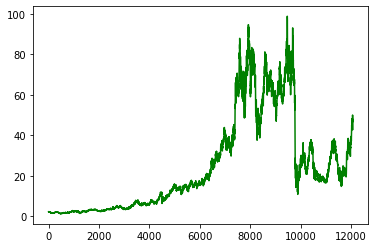

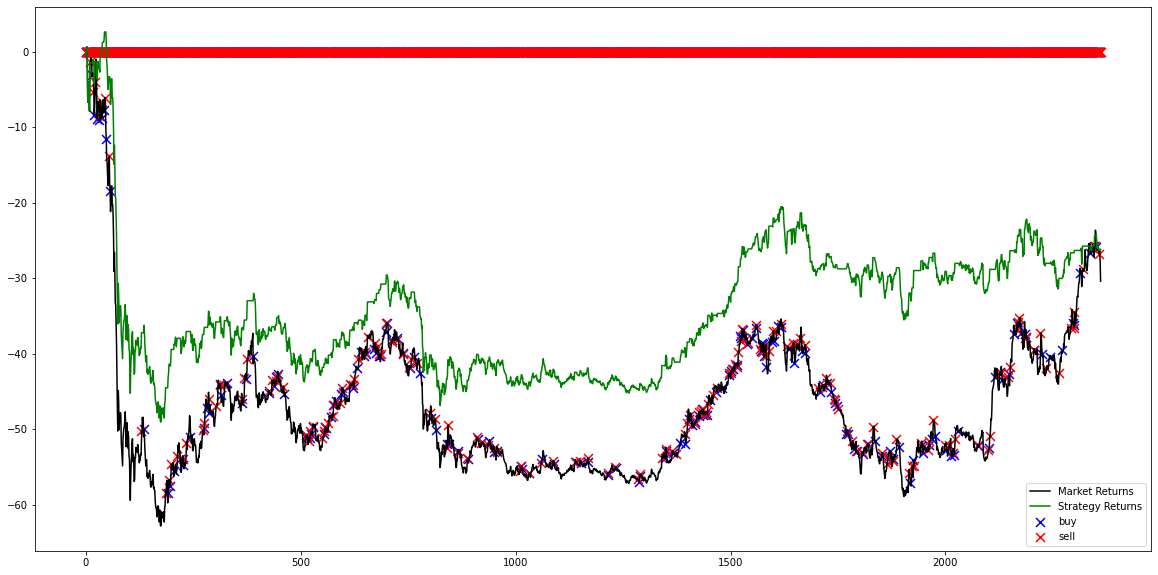

Total market return: -30.373999999999945
Total strategy return: -26.15299999999993
Total number of purchases prediction: 177
Total number of actual purchases: 1753
Total correct predicted days: 866
Total number of days: 2362


In [34]:
path = "../data/Stocks/"
files = listdir(path)

# Remove the list limiter [0:1] from files[0:1] in order to train the model with all the data
for indx, file in enumerate(files[0:1]):
    print("Nr. "+str(indx) +"/"+ str(len(files[0:1])))
    dataset = pd.DataFrame()
    dataset = pd.read_csv(path + "aa.us.txt")
    if len(dataset) < 800 and indx != 0:
        print("Dataset smaller then 800 skipping ...")
        continue

    # Casting the data to float
    dataset["Open"] = dataset["Open"].astype(float)
    dataset["High"] = dataset["High"].astype(float)
    dataset["Low"] = dataset["Low"].astype(float)
    dataset["Close"] = dataset["Close"].astype(float)

    # Plotting stock closing price
    plt.plot(dataset["Close"],color='g', label='close price')

    # Remove unmeaningfull data 
    dataset = dataset.dropna()
    dataset = dataset.reset_index()
    dataset = dataset[['Close', 'High', 'Low', 'Open']]

    # Engineering data
    dataset = add_analysis_to_dataset(dataset)
    dataset.head()

    #Cleaning
    dataset.dropna(inplace=True)
    X = dataset.drop(columns=["returns"]).values

    #Scaling
    scaler = MinMaxScaler(feature_range=(0,1)).fit(X)
    x_scaled = scaler.transform(X)

    #Splitting data
    y = [x[0] for x in x_scaled]
    split = int(len(x_scaled) *0.8)

    x_train = x_scaled[:split]
    x_test = x_scaled[split: len(x_scaled)]
    y_train = y[:split]
    y_test = y[split : len(y)]

    n = 35
    xtrain = []
    ytrain = []
    xtest = []
    ytest = []

    for i in range(n, len(x_train)):
        xtrain.append(x_train[i-n : i, : x_train.shape[1]])     # i = 35 , n = 35 , x_train.shape[1] = 89
        ytrain.append(y_train[i]) # i = 35
    for i in range(n, len(x_test)):
        xtest.append(x_test[i-n : i, : x_test.shape[1]])
        ytest.append(y_test[i])
        
    xtrain, ytrain = (np.array(xtrain), np.array(ytrain))
#     xtrain = np.reshape(xtrain, (xtrain.shape[0],xtrain.shape[1], xtrain.shape[2]))

    xtest, ytest = (np.array(xtest), np.array(ytest))
#     xtest = np.reshape(xtest,(xtest.shape[0], xtest.shape[1], xtest.shape[2]))

    # Creating model
    if indx == 0:
        model = create_LSTM_model((xtrain.shape[1], xtrain.shape[2]))
       
    # Training model
    model.fit(xtrain, ytrain, epochs=18, validation_data=(xtest,ytest), batch_size=126, verbose=1)
    
    # Predicting
    trainpredict = model.predict(xtrain)
    testpredict = model.predict(xtest)

    # Rescaling data
    trainpredict, testpredict, ytestscaled = rescale_data(trainpredict, testpredict, scaler, ytest)

    # Assessing model
    trade_dataset = generate_triggers(testpredict, ytestscaled)  

    # Preparing output for validation
    plot_results(trade_dataset)

# Use when you want to save the trained model 
# model.save('../models/LSTM_v7') 

## LSTM_v6 in the folder /models is trained on 500 stocks
 


### Predict with model


In [20]:
model = models.load_model("../models/models/LSTM_v6") 

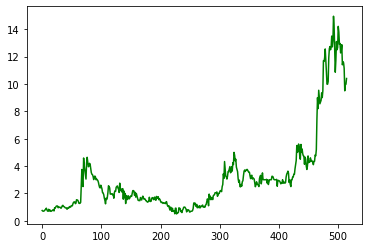

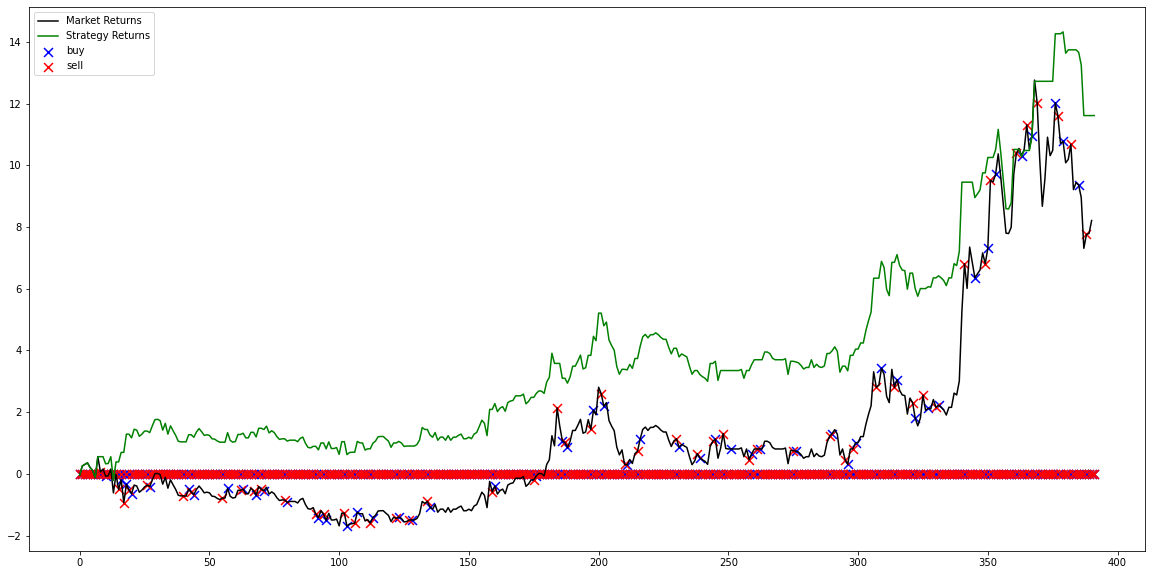

Total market return: 8.210000000000003
Total strategy return: 11.609599999999999
Total number of purchases prediction: 51
Total number of actual purchases: 314
Total correct predicted days: 154
Total number of days: 392


In [25]:
path = "../data/Stocks/"
files = listdir(path)

for indx, file in enumerate(files[30:31]):
    dataset = pd.DataFrame()
    dataset = pd.read_csv(path + file)

    dataset["Open"] = dataset["Open"].astype(float)
    dataset["High"] = dataset["High"].astype(float)
    dataset["Low"] = dataset["Low"].astype(float)
    dataset["Close"] = dataset["Close"].astype(float)

    plt.plot(dataset["Close"],color='g', label='close price')

    dataset = dataset.reset_index()
    dataset = dataset[['Close', 'Open', 'High', 'Low']]
    dataset = dataset.dropna()

    dataset = add_analysis_to_dataset(dataset)
    dataset.dropna(inplace=True)
    X = dataset.drop(columns=["returns"]).values

    scaler = MinMaxScaler(feature_range=(0,1)).fit(X)
    x_scaled = scaler.transform(X)

    n = 35
    x = []

    for i in range(n, len(x_scaled)):
        x.append(x_scaled[i-n : i, : x_scaled.shape[1]])

    x= np.array(x)
    x = np.reshape(x, (x.shape[0],x.shape[1], x.shape[2]))

    predict = model.predict(x)

    z1 = np.zeros(predict.shape)
    zero = len(X[0])-1

    for i in range(zero):
        predict = np.c_[predict, z1]

    predict = scaler.inverse_transform(predict)
    predict = [x[0] for x in predict]

    df = dataset[["Close"]][35:]
    df["preds"] = predict
    df = df.dropna()

    df["change"] = df.apply(lambda x: x["preds"] - x["Close"] ,axis=1)
    df["trigger"] = np.where((df["change"]>0.3) & (df["change"]<2),1,0)
    
    pred = df["trigger"] == 1
    y_pred = np.array(pred)

    df['y_pred'] = y_pred

    trade_dataset = df.dropna().reset_index()
    # Preparing output for validation
    plot_results(trade_dataset)
